# НИРС

## Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.

В качестве набора данных будет использоваться набор данных The Boston Housing Dataset:  
https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset

Датасет состоит из одного файла HousingData.csv

Набор данных создан на основе информации, собранной Службой переписи населения США о жилье в районе Бостона, штат Массачусетс. Ниже описаны столбцы набора данных:

- `CRIM` - уровень преступности на душу населения по городу
- `ZN` - доля жилой земли, зонированной для участков площадью более 25 000 кв. футов.
- `INDUS` - доля акров земли, не предназначенной для розничной торговли, по городам.
- `CHAS` - фиктивная переменная Charles River (1, если участок огибает реку; 0 в противном случае).
- `NOX` - концентрация оксидов азота (частей на 10 миллионов).
- `RM` - среднее количество комнат на одно жилище
- `AGE` - доля домов, занятых владельцами, построенных до 1940 года.
- `DIS` - взвешенные расстояния до пяти бостонских центров занятости
- `RAD` - индекс доступности радиальных магистралей
- `TAX` - ставка налога на полную стоимость недвижимости на $10 000
- `PTRATIO` - соотношение числа учеников и учителей по городам
- `B` - 1000(Bk - 0.63)^2, где Bk - доля чернокожих в городе
- `LSTAT` - % населения с более низким статусом
- `MEDV` - медианная стоимость домов, занимаемых владельцами, в 1000 долларов

В данной работе будет решаться задача **регрессии**. В качестве целевого признака будем использовать поле `MEDV`.


## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sns.set(style="ticks")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Загрузка данных

In [2]:
data = pd.read_csv('HousingData.csv', sep=',')

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
data.shape

(506, 14)

In [5]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [6]:
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Удаление дубликатов

In [7]:
data = data.drop_duplicates()
data.shape

(506, 14)

Проверка нулевых значений

In [8]:
data.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

Анализ и заполнение пропусков

Колонка CRIM. Количество пустых значений: 20, 3.95%.


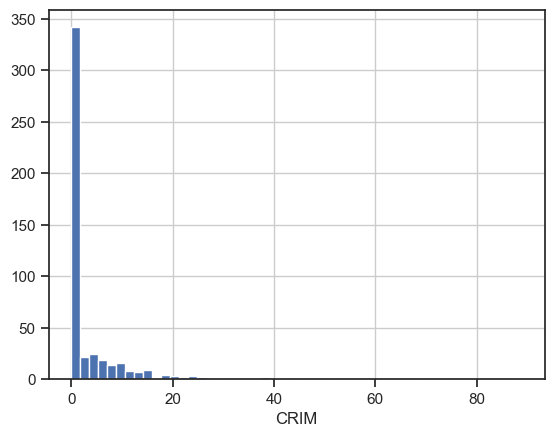

Колонка ZN. Количество пустых значений: 20, 3.95%.


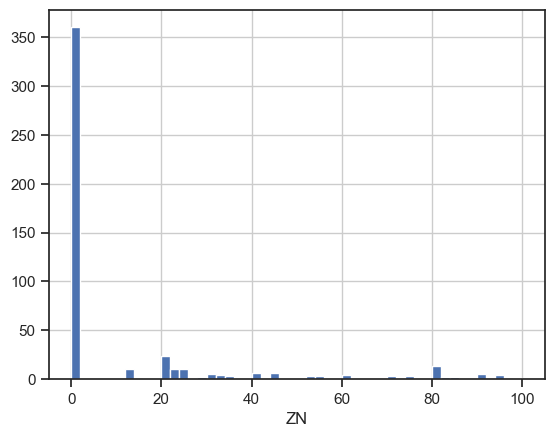

Колонка INDUS. Количество пустых значений: 20, 3.95%.


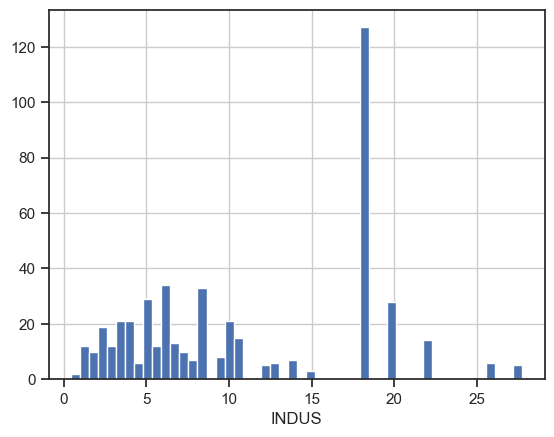

Колонка CHAS. Количество пустых значений: 20, 3.95%.


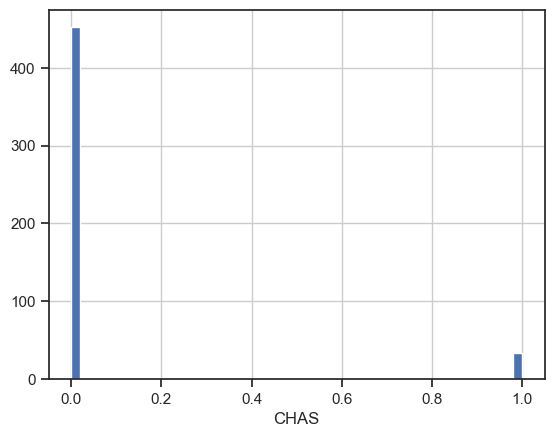

Колонка AGE. Количество пустых значений: 20, 3.95%.


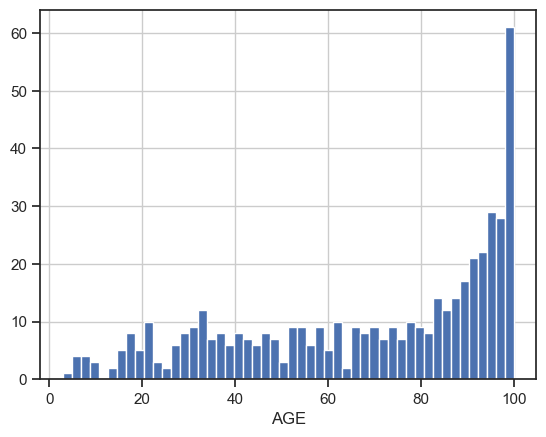

Колонка LSTAT. Количество пустых значений: 20, 3.95%.


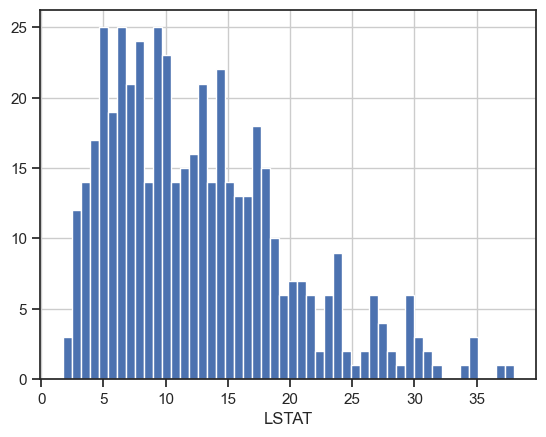

In [9]:
null_cols = []
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    null_count = data[col].isnull().sum()
    if null_count > 0:
        null_cols.append(col)
        print(f'Колонка {col}. Количество пустых значений: {null_count}, {round((null_count / len(data)) * 100, 2)}%.')
        data[col].hist(bins=50)
        plt.xlabel(col)
        plt.show()

Для заполнения пропусков используем случайный лес

In [10]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def random_forest_impute(data, column, is_classification=False):
    df = data.copy()
    
    known = df[df[column].notna()]
    unknown = df[df[column].isna()]
    
    if unknown.empty:
        return df
    
    X_known = known.drop(column, axis=1)
    y_known = known[column]
    
    X_unknown = unknown.drop(column, axis=1)
    
    if is_classification:
        model = RandomForestClassifier()
    else:
        model = RandomForestRegressor()
    
    model.fit(X_known, y_known)
    
    predicted_values = model.predict(X_unknown)
    
    df.loc[df[column].isna(), column] = predicted_values
    
    return df

data_imputed = data.copy()
for col in null_cols:
    if data_imputed[col].dtype == 'object' or len(data_imputed[col].unique()) <= 20:
        data_imputed = random_forest_impute(data_imputed, col, is_classification=True)
    else:
        data_imputed = random_forest_impute(data_imputed, col, is_classification=False)

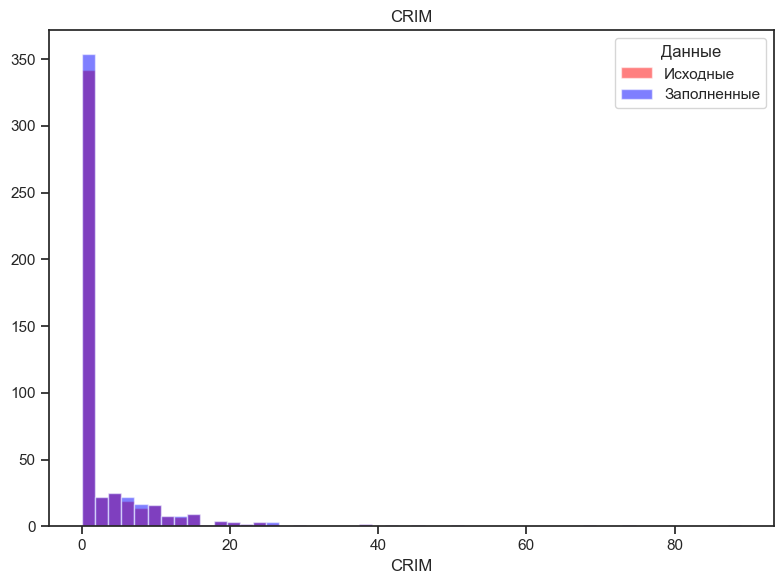

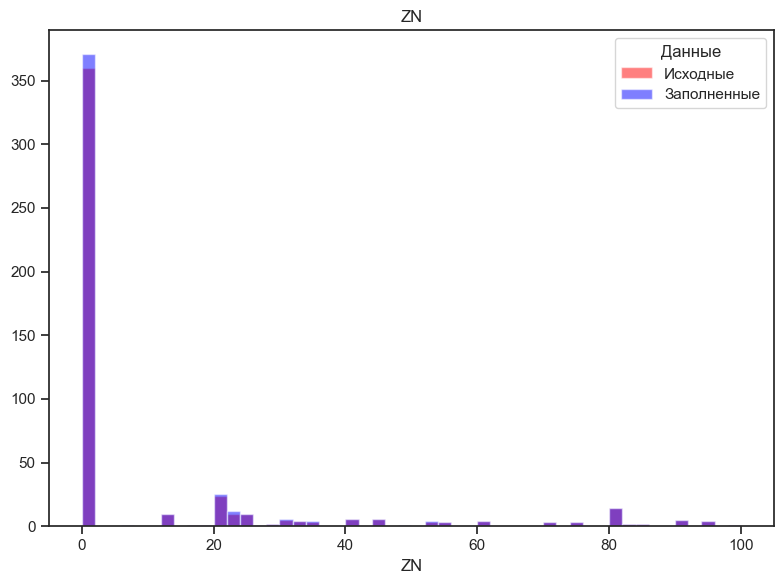

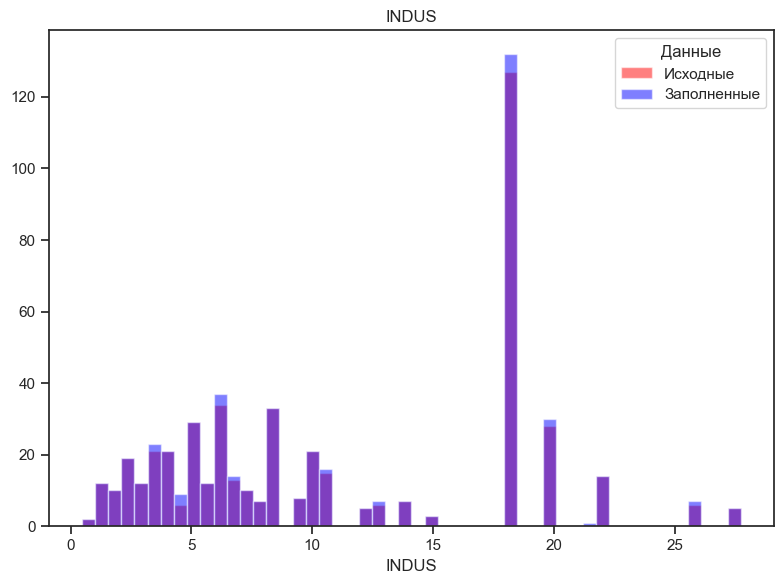

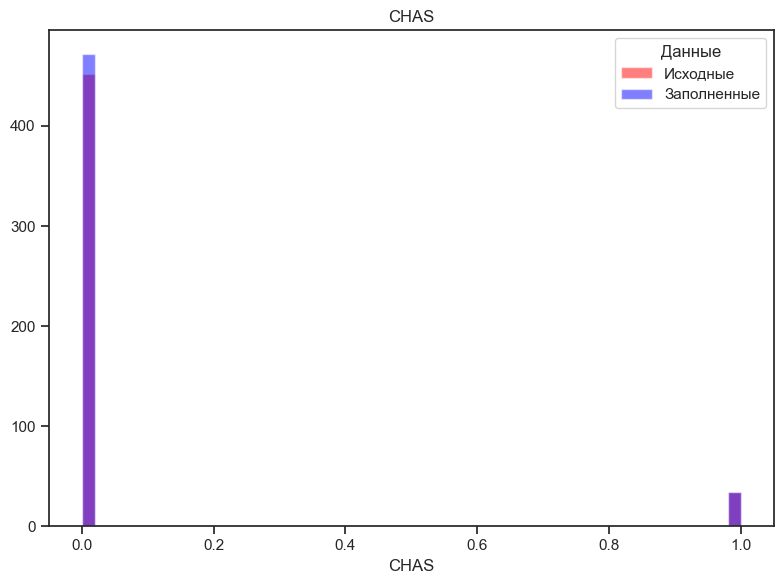

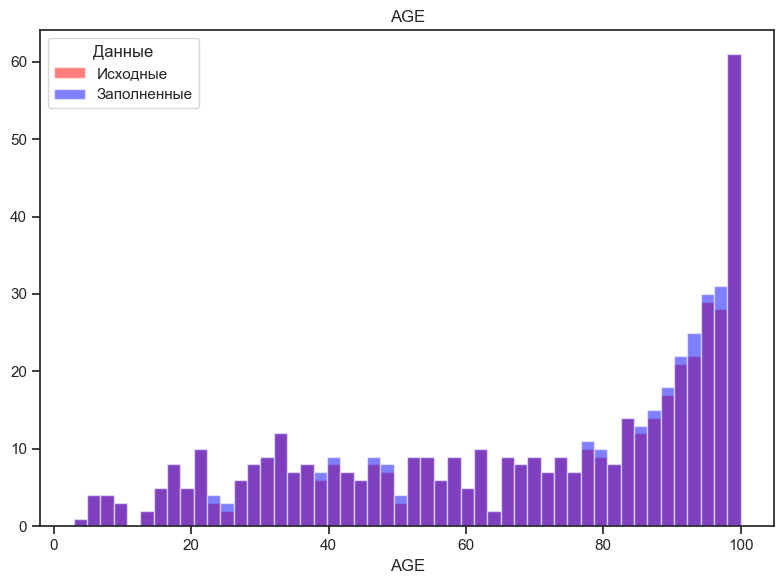

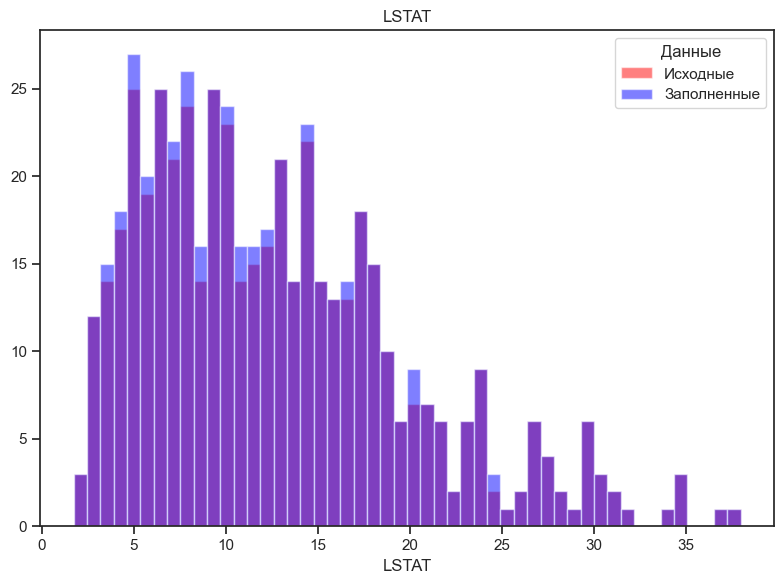

In [11]:
import matplotlib.pyplot as plt

for col in null_cols:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(data[col], bins=50, alpha=0.5, label='Исходные', color='red')
    ax.hist(data_imputed[col], bins=50, alpha=0.5, label='Заполненные', color='blue')
    
    ax.set_xlabel(col)
    ax.set_title(f'{col}')
    ax.legend(title='Данные')
    
    plt.tight_layout()
    plt.show()


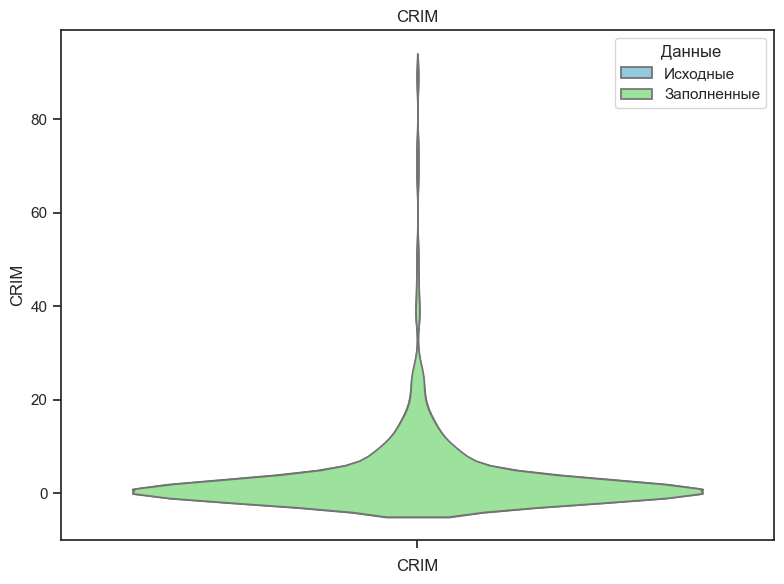

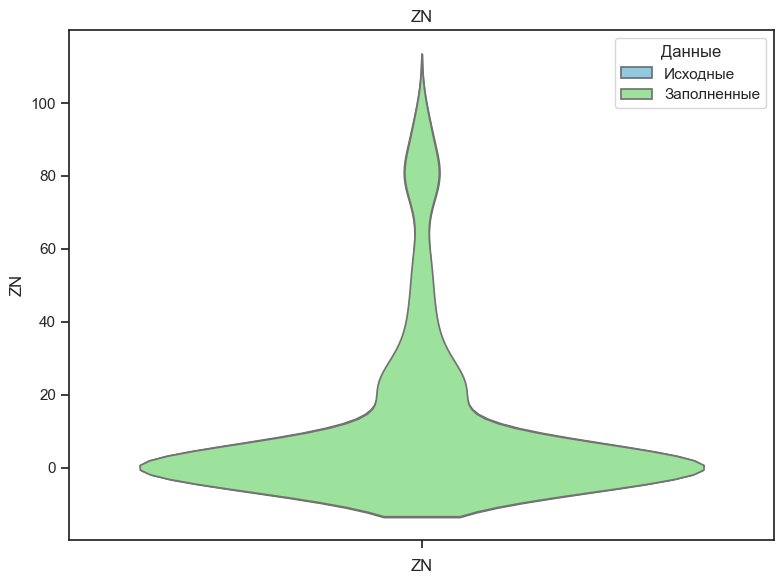

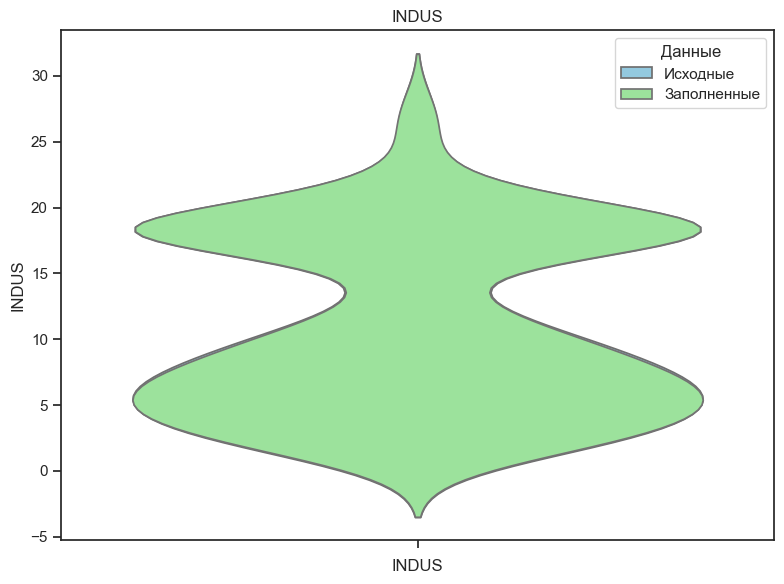

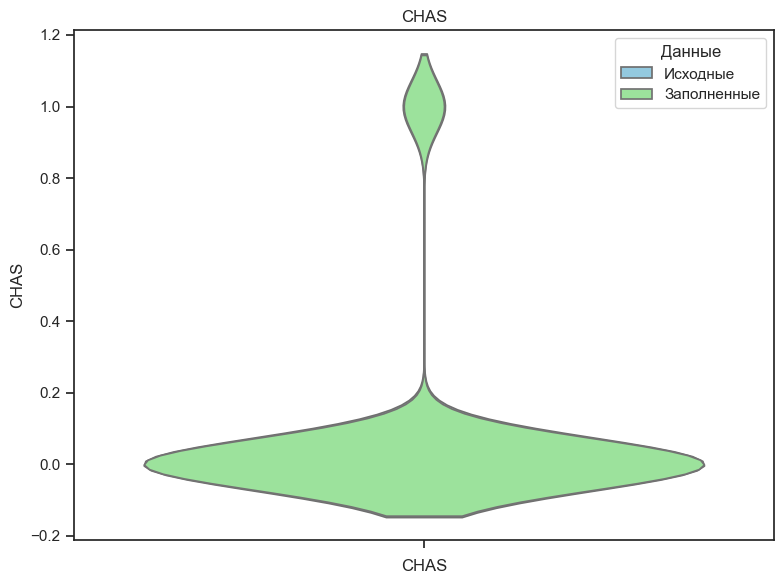

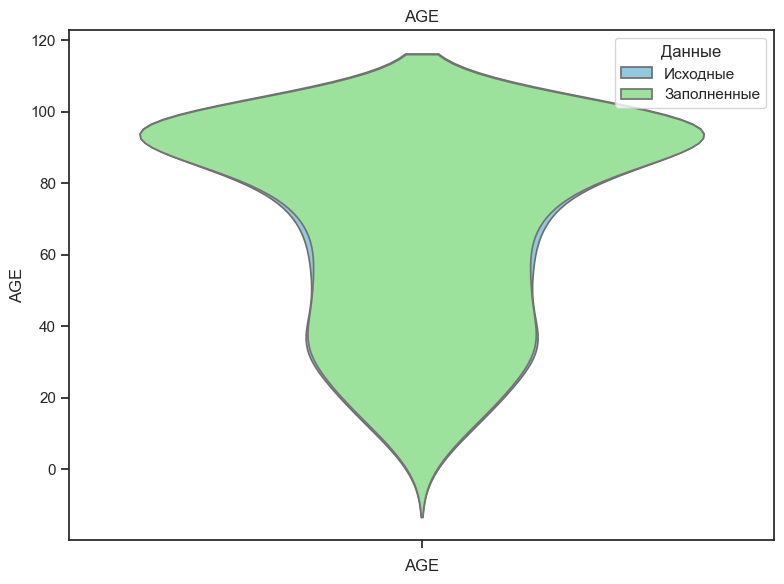

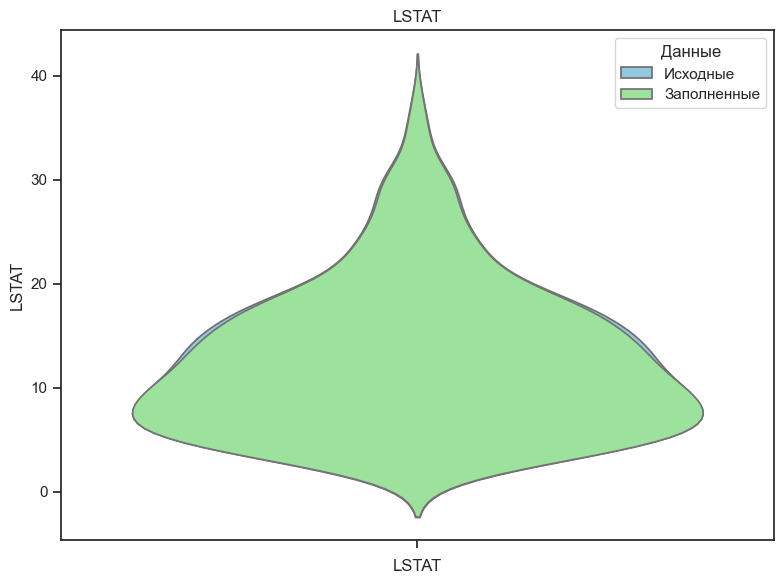

In [12]:
for col in null_cols:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.violinplot(data=data[col], color='skyblue', ax=ax, inner=None, label='Исходные')
    sns.violinplot(data=data_imputed[col], color='lightgreen', ax=ax, inner=None, label='Заполненные')
    
    ax.set_xlabel(col)
    ax.set_title(f'{col}')
    ax.legend(title='Данные')
    
    plt.tight_layout()
    plt.show()

**Вывод**: очистили датасет от дупликатов, заполнили пропуски, максимально сохранив распределение значений.

## Построение графиков для понимания структуры данных

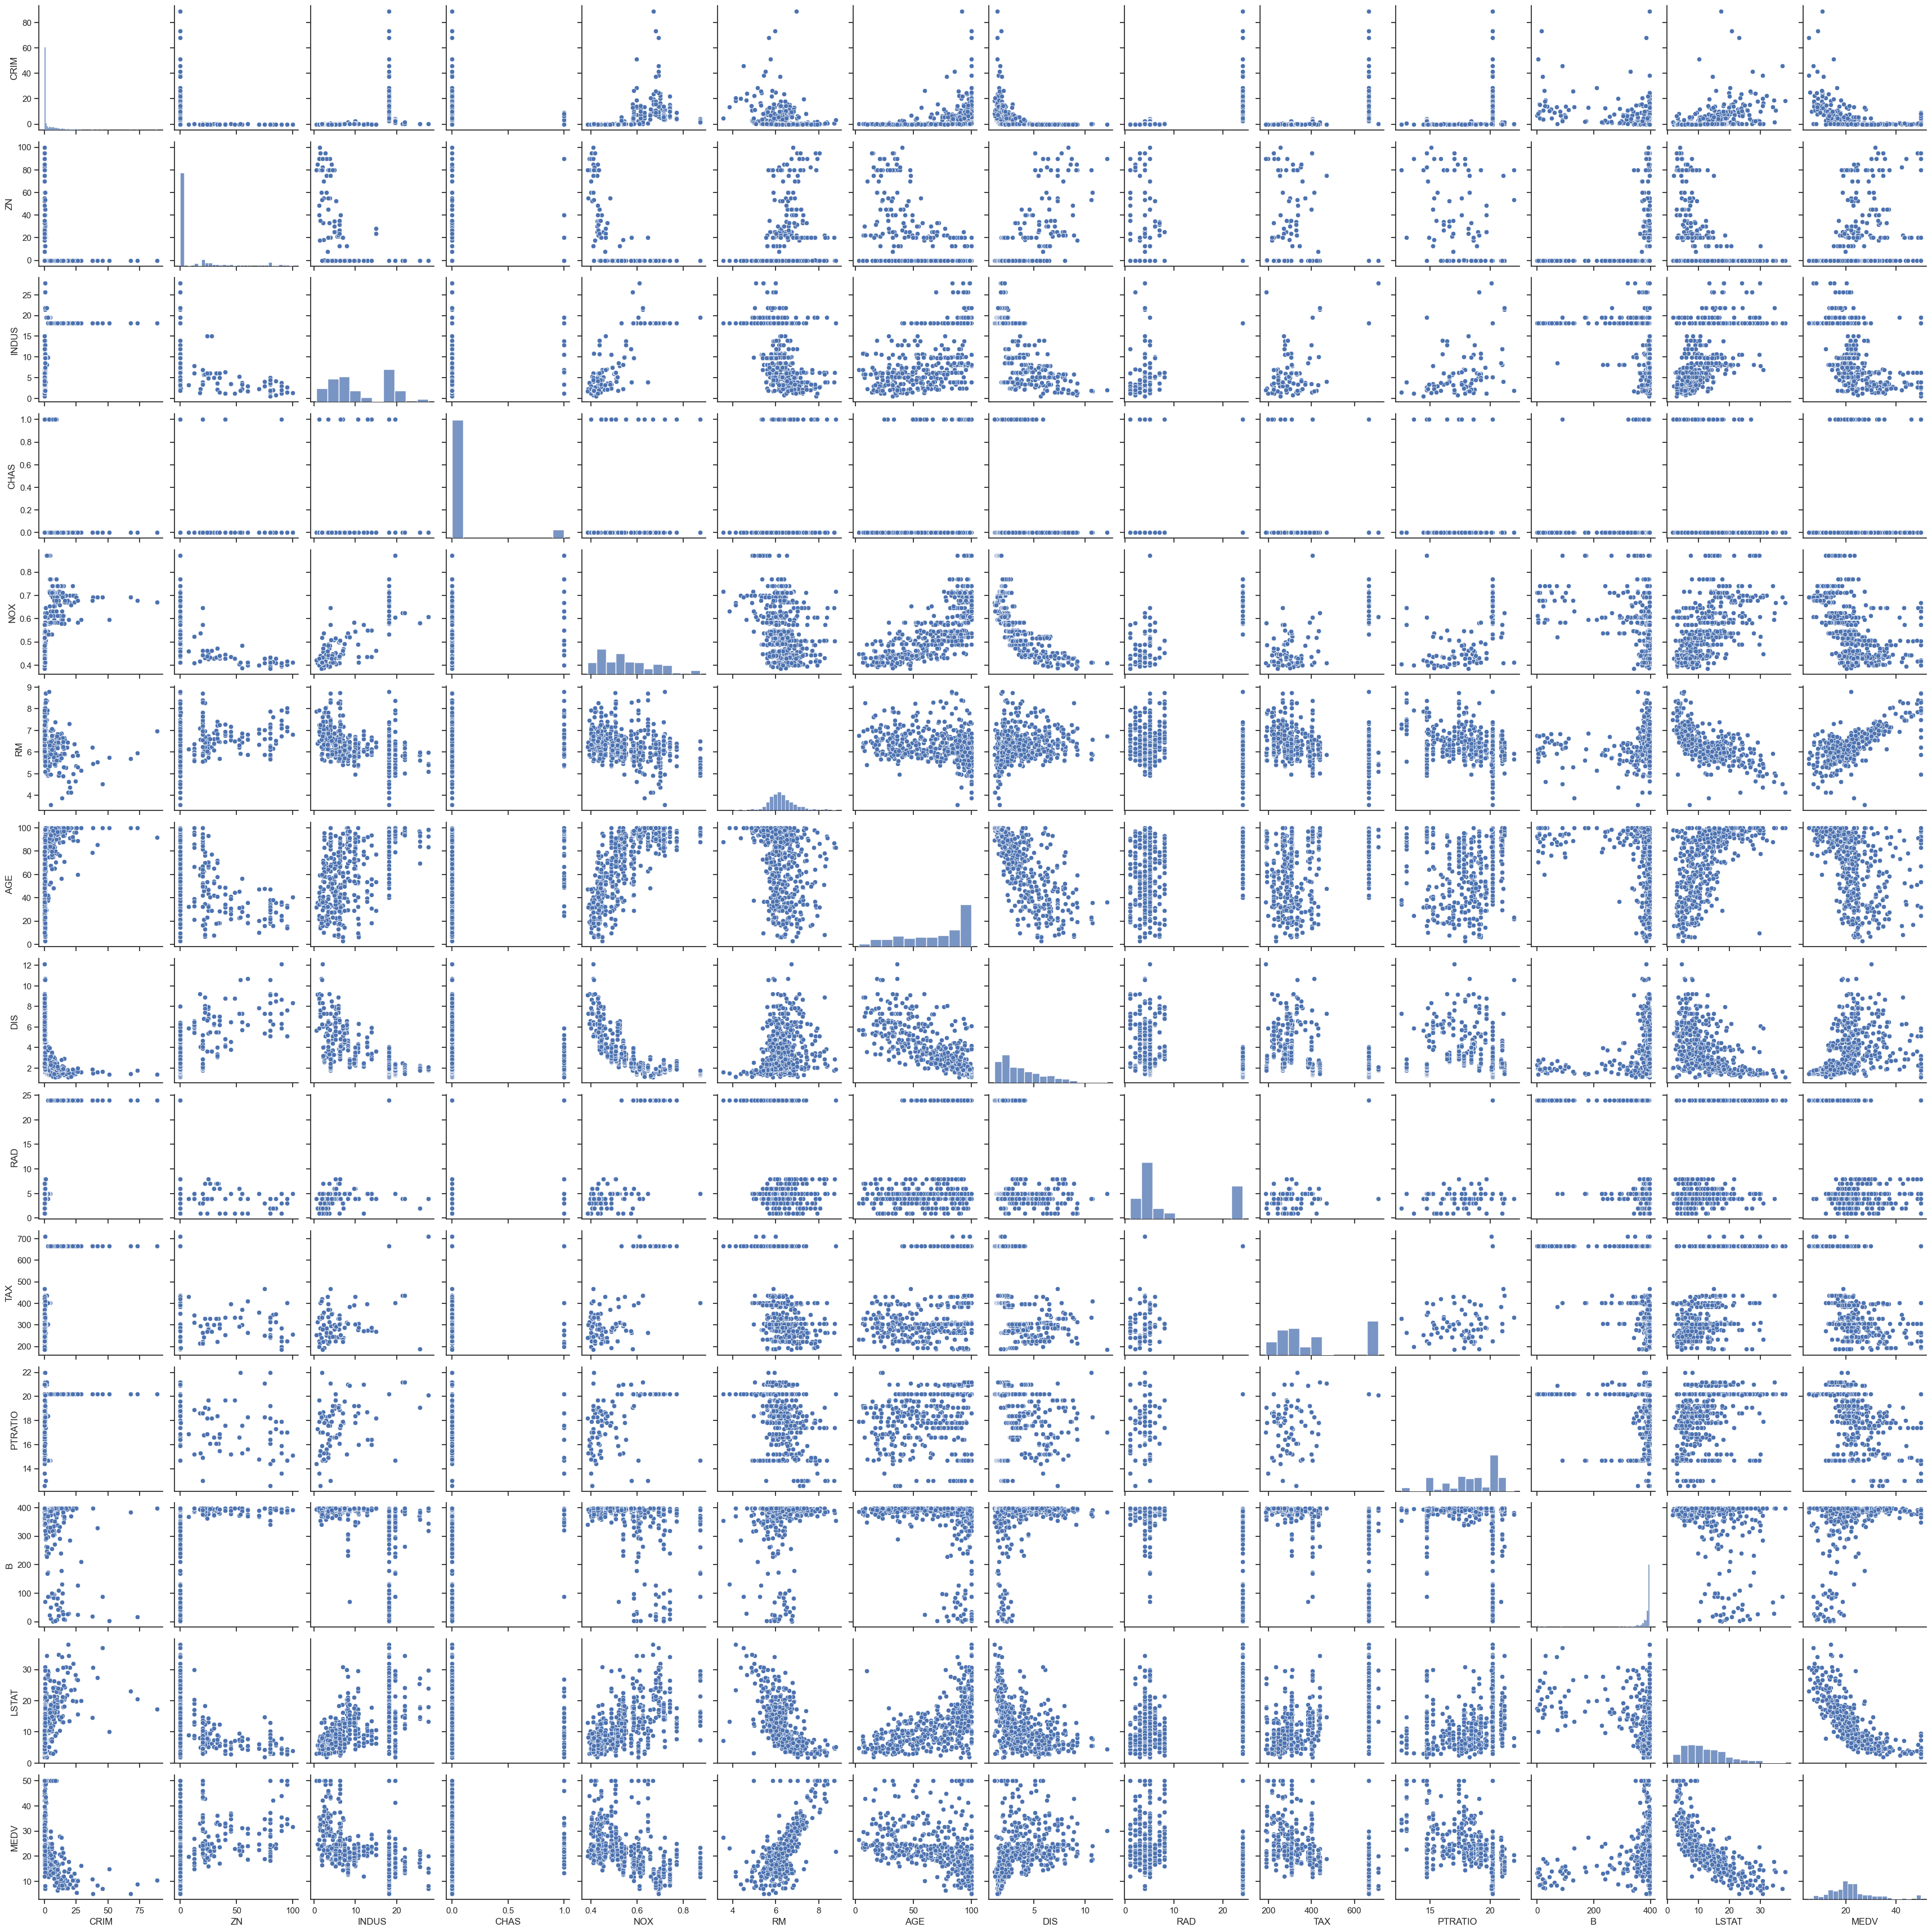

In [13]:
sns.pairplot(data_imputed)

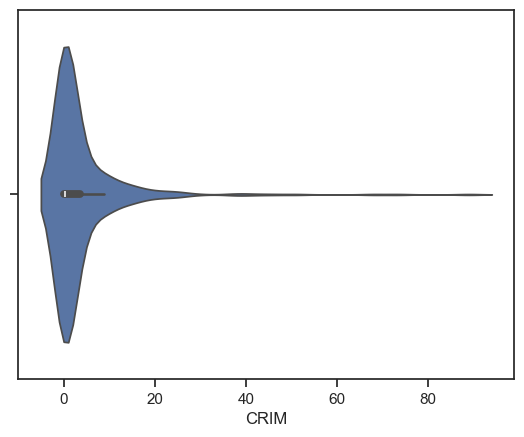

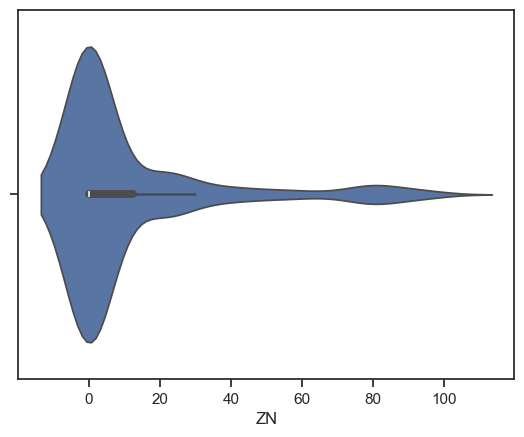

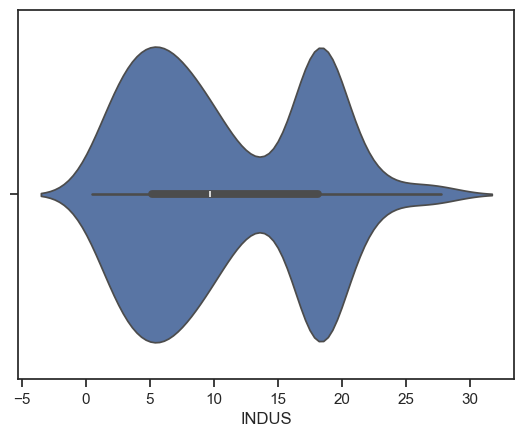

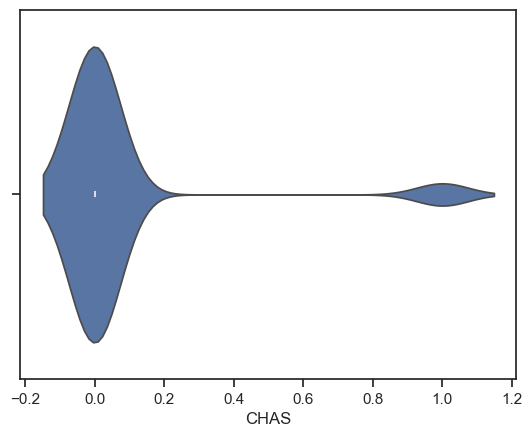

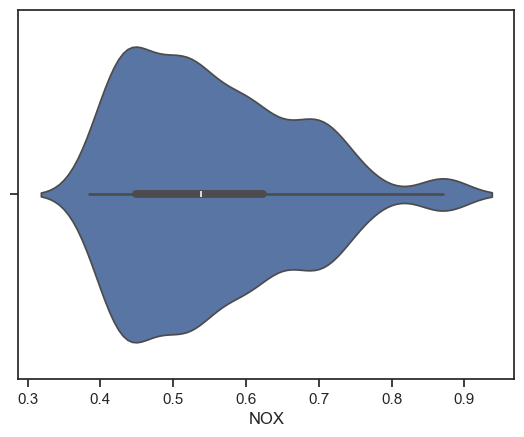

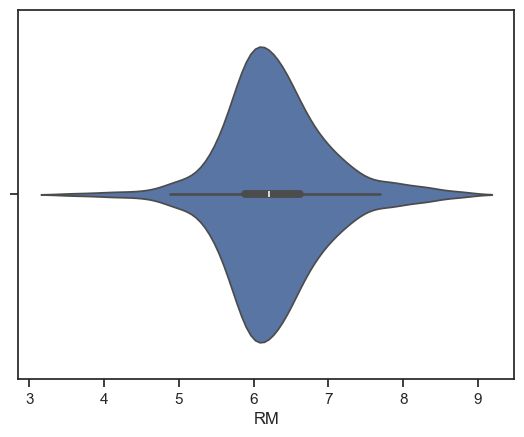

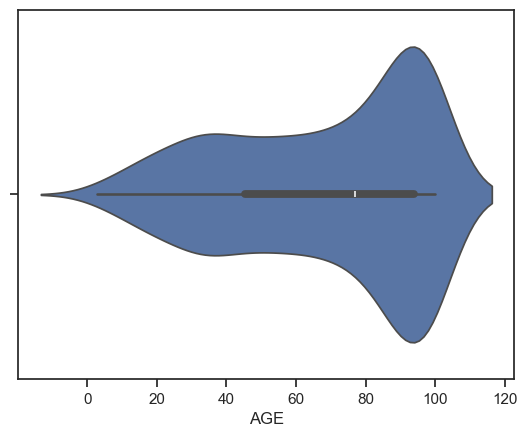

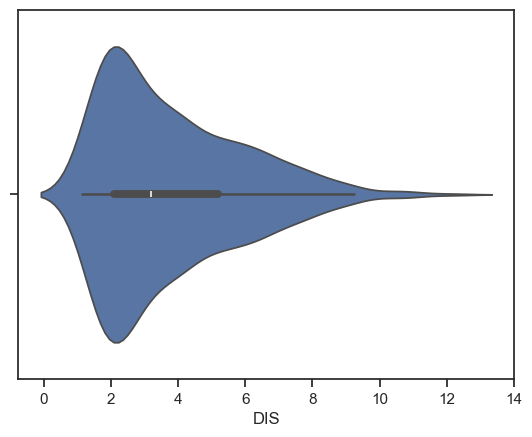

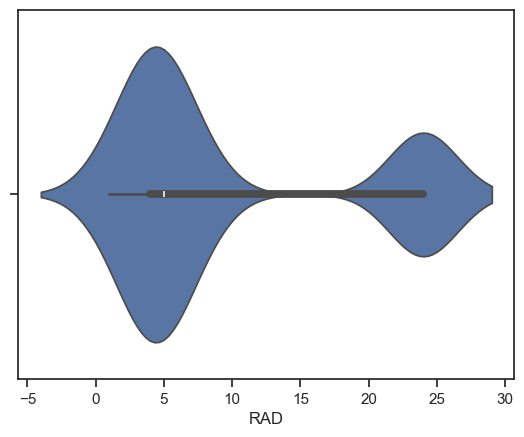

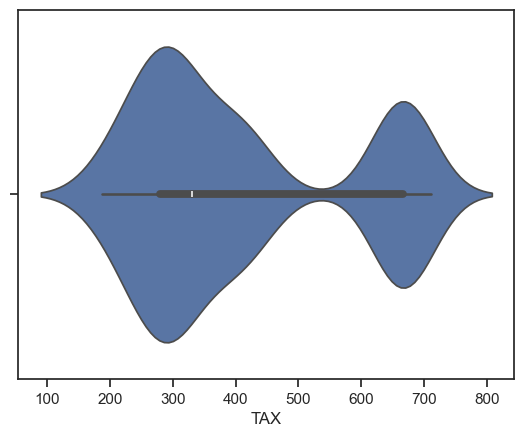

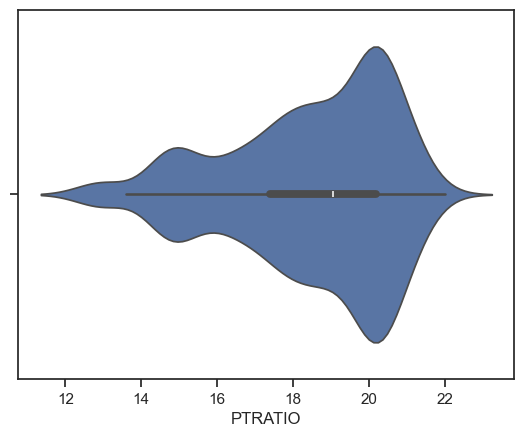

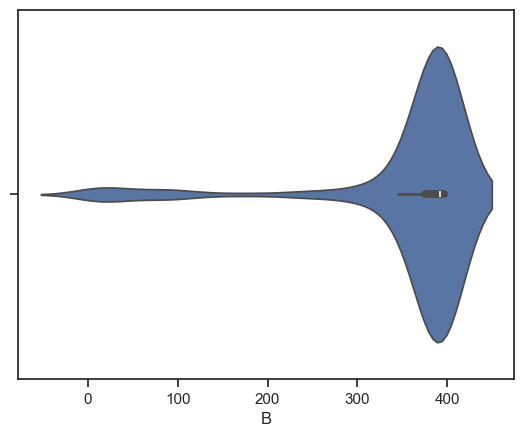

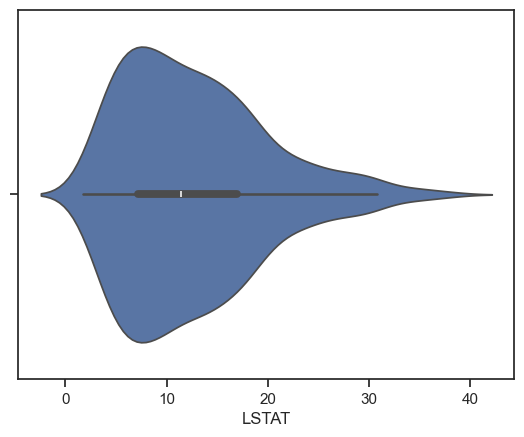

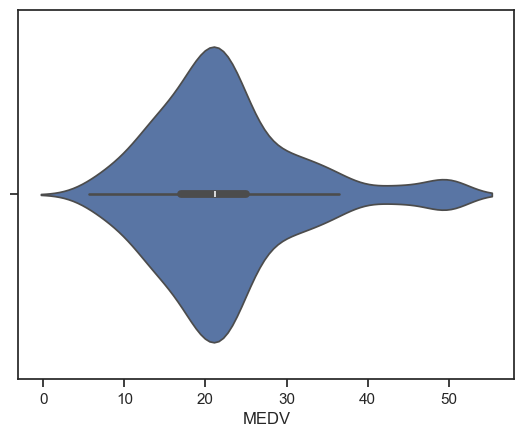

In [14]:
for col in data_imputed.columns:
    sns.violinplot(x=data[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [15]:
data_imputed.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Масштабирование данных

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data.columns)

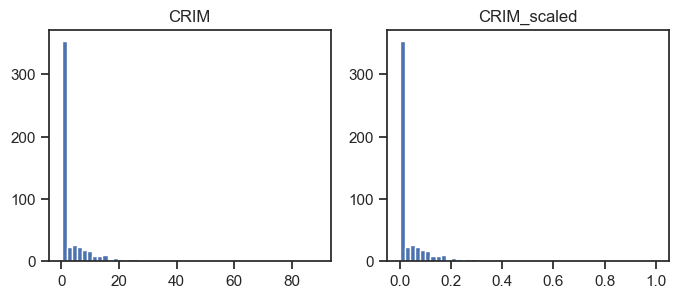

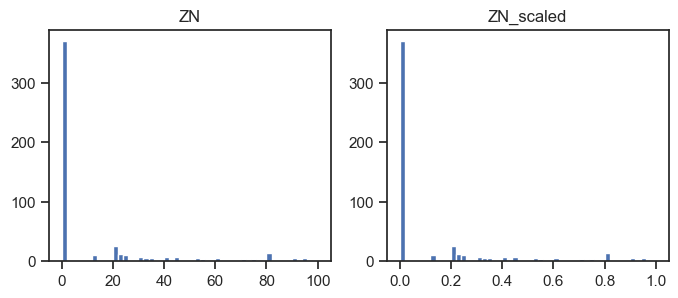

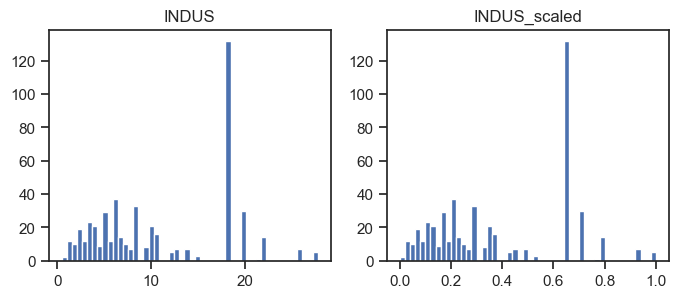

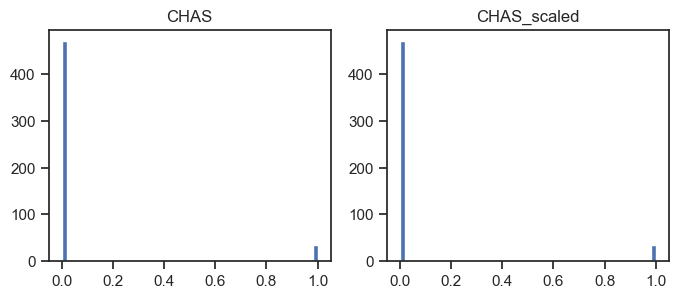

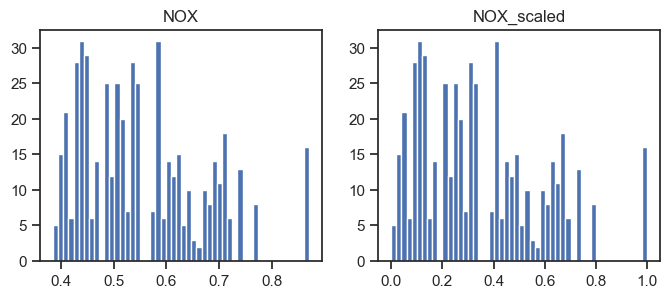

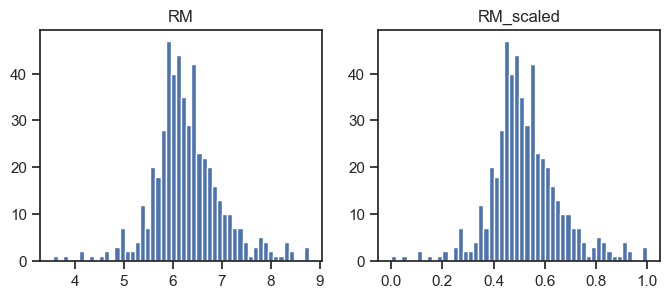

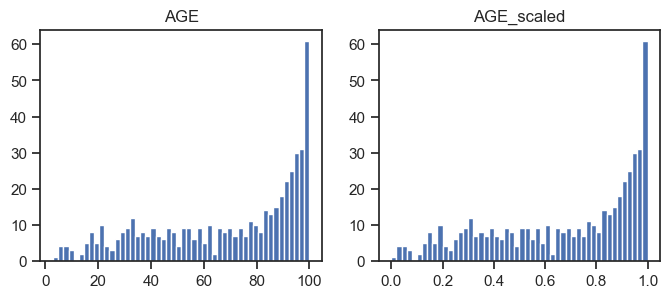

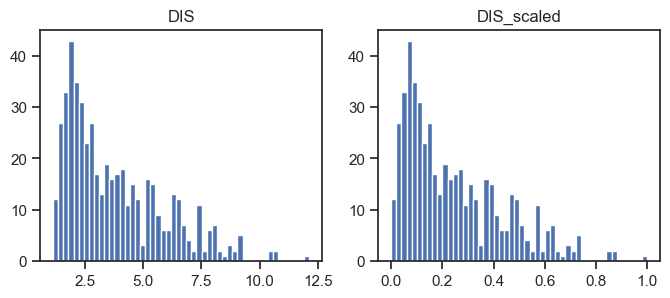

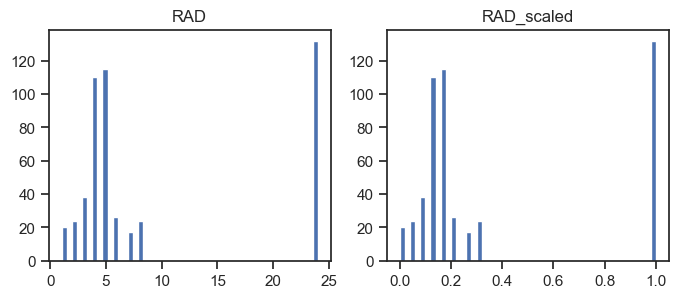

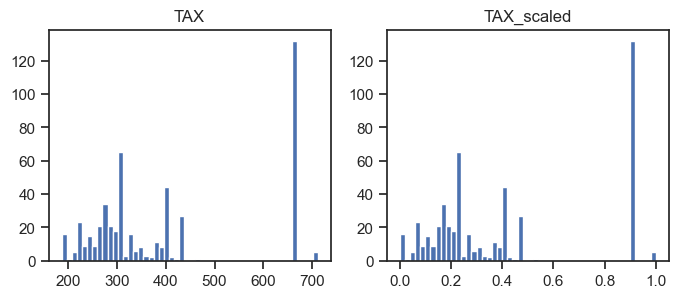

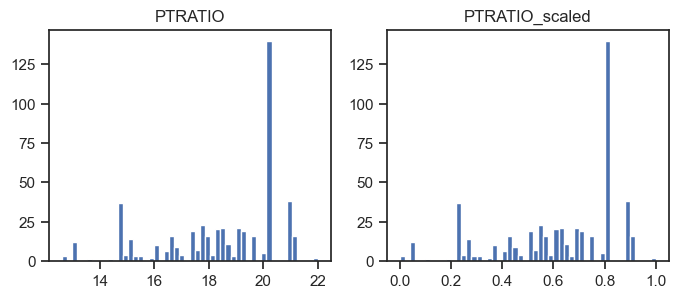

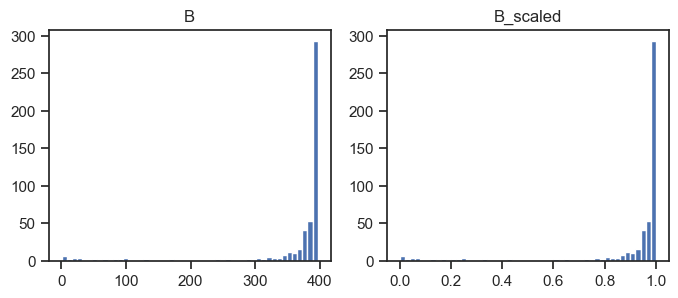

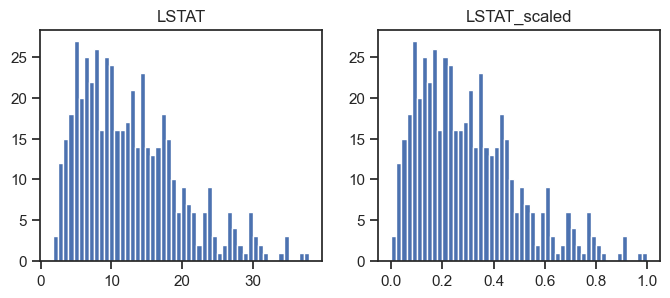

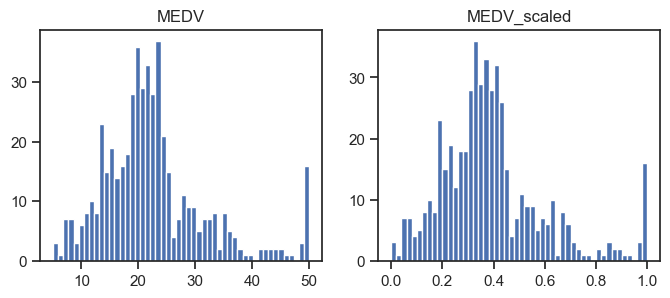

In [17]:
for col in data.columns:    
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data_imputed[col], 50)
    ax[0].title.set_text(col)
    
    ax[1].hist(data_scaled[col], 50)
    ax[1].title.set_text(col + '_scaled')
    plt.show()

In [18]:
data_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.081719,0.693333


## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

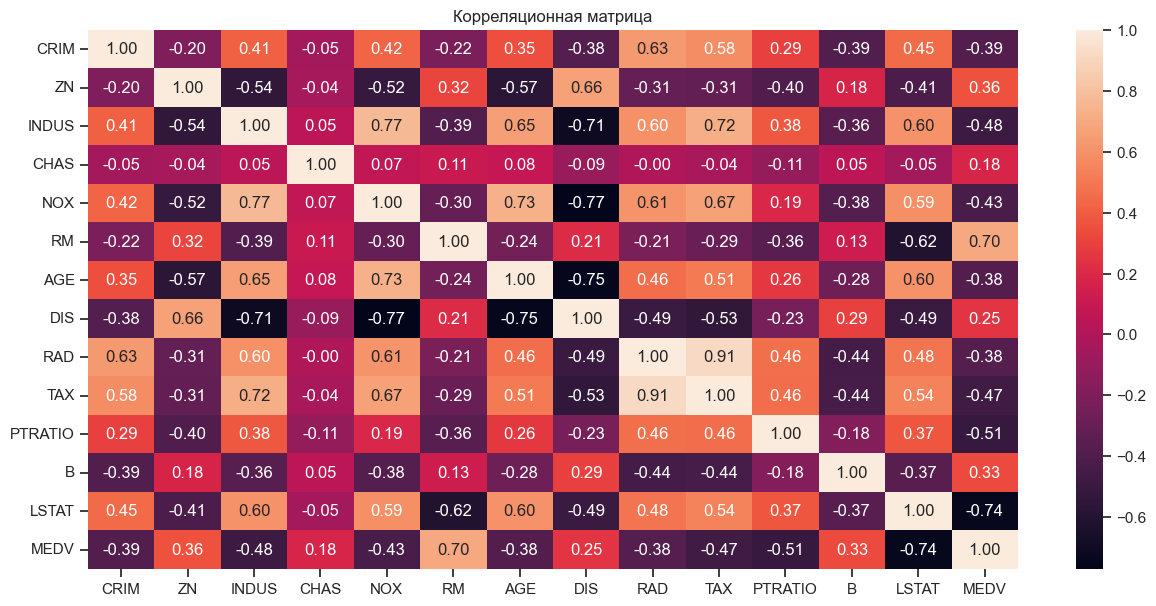

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data_scaled.corr(), annot=True, fmt='.2f')
ax.set_title('Корреляционная матрица')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:
- Целевой признак `MEDV` сильно коррелирует с признаком `LSTAT` `(-0,74)`, `RM` `(0,7)`.
- `DIS`, `TAX` и `NOX` сильно коррелируют с несколькими признаками и друг с другом, поэтому их тоже надо удалить.

Среди остальных признаков нет слишком сильной корреляции друг с другом, коэффициенты корреляции, в основном, не превосходят по модулю 0.5. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения

In [20]:
data_scaled.drop(columns=['DIS', 'TAX', 'NOX'], inplace=True)

In [21]:
data_scaled.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.577505,0.641607,0.000000,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0.0,0.547998,0.782698,0.043478,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0.0,0.694386,0.599382,0.043478,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0.0,0.658555,0.441813,0.086957,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0.0,0.687105,0.528321,0.086957,0.648936,1.000000,0.081719,0.693333


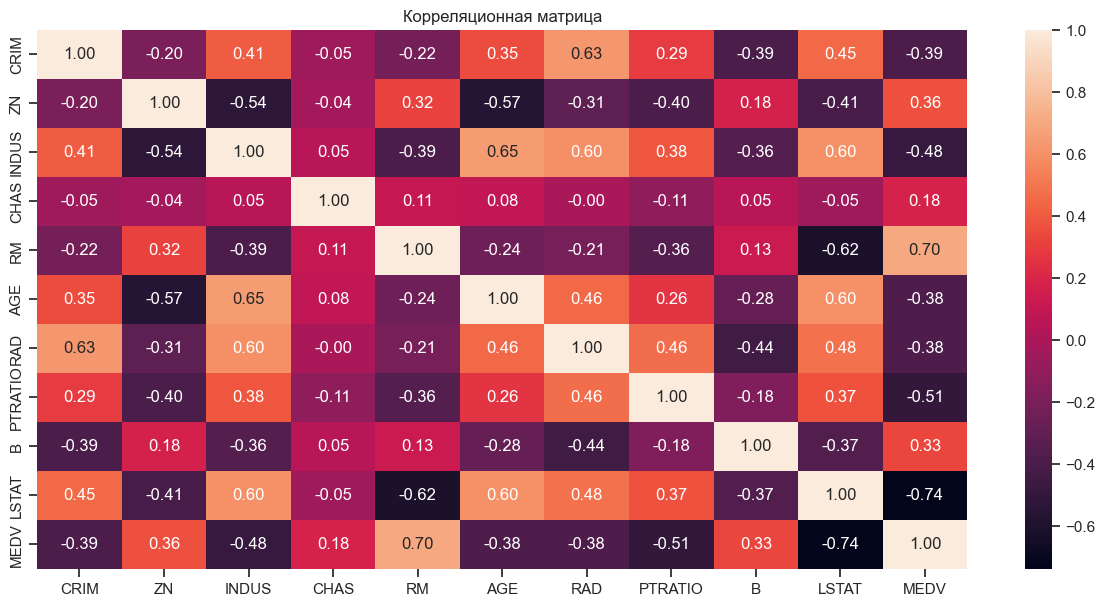

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data_scaled.corr(), annot=True, fmt='.2f')
ax.set_title('Корреляционная матрица')
plt.show()

## Выбор метрик для последующей оценки качества моделей

### В качестве метрик для решения задачи регрессии будем использовать:
- #### **Mean Absolute Error - средняя абсолютная ошибка**
$$MAE(y,\hat{y})=\frac{1}{N}\Sigma^{N}_{i=1}|y_i−\hat{y_i}|$$
где:

$$y\text{ - истинное значение целевого признака} $$
$$\hat{y} \text{- предсказанное значение целевого признака}$$
$$N \text{- размер тестовой выборки}$$

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции mean_absolute_error.

- #### **Median Absolute Error - медианная абсолютная ошибка**

$$MedAE(y,\hat{y}) = median( \lvert  y_1 - \hat{y_1} \rvert, \dots, \lvert  y_N - \hat{y_N} \rvert)$$

Метрика интересна тем, что является устойчивой к выбросам в данных.

Вычисляется с помощью функции median_absolute_error.

- #### **Root Mean Squared Error - средняя квадратичная ошибка**
$$RMSE(y,\hat{y}) = \sqrt{MSE(y,\hat{y})} = \sqrt{ \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2} $$
где:

$$y \text{- истинное значение целевого признака}$$
$$\hat{y} \text{- предсказанное значение целевого признака}$$
$$N \text{- размер тестовой выборки}$$
 
Вычисляется с помощью функции root_mean_squared_error.

- #### **Метрика R2**
 или коэффициент детерминации
$$R^2(y,\hat{y} )=1− \frac{\Sigma^{N}_{i=1} (y_i - \hat{y_i^2})}{\Sigma^{N}_{i=1} (y_i - \hat{y_i^2})}$$
где:

$$y \text{ - истинное значение целевого признака}$$
$$\hat{y} \text{- предсказанное значение целевого признака}$$
$$N \text{- размер тестовой выборки}$$
$$\overline{y_i}=\frac{1}{N} \cdot \Sigma^{N}_{i=1}y_i$$
Вычисляется с помощью функции r2_score.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
import pandas as pd

class ModelTester:
    def __init__(self):
        self.models = []
        self.metrics = {
            "Model": [],
            "Mean_AE": [],
            "Median_AE": [],
            "RMSE": [],
            "R2": []
        }
        self.tuned_flags = []

    def add_model(self, model, name=None, tuned=False):
        def model_exists(new_model):
            for existing_model, _, _ in self.models:
                if new_model.get_params() == existing_model.get_params():
                    return True
            return False

        if isinstance(model, list):
            for m in model:
                if not model_exists(m):
                    model_name = name if name is not None else m.__class__.__name__
                    self.models.append((m, model_name, tuned))
        else:
            if not model_exists(model):
                model_name = name if name is not None else model.__class__.__name__
                self.models.append((model, model_name, tuned))

    def train_models(self, X_train, y_train):
        for model, name, tuned in self.models:
            try:
                check_is_fitted(model)
            except NotFittedError:
                model.fit(X_train, y_train)

    def test_models(self, X_test, y_test):
        self.metrics = {
            "Model": [],
            "Mean_AE": [],
            "Median_AE": [],
            "RMSE": [],
            "R2": []
        }
        self.tuned_flags = []

        for model, name, tuned in self.models:
            try:
                check_is_fitted(model)
            except NotFittedError:
                raise NotFittedError(f"Модель {name} не обучена. Сначала вызовите `train_models`.")
            
            predictions = model.predict(X_test)
            model_label = f"{name} (tuned)" if tuned else name
            self.metrics["Model"].append(model_label)
            self.metrics["Mean_AE"].append(mean_absolute_error(y_test, predictions))
            self.metrics["Median_AE"].append(median_absolute_error(y_test, predictions))
            self.metrics["RMSE"].append(np.sqrt(mean_squared_error(y_test, predictions)))
            self.metrics["R2"].append(r2_score(y_test, predictions))
            self.tuned_flags.append(tuned)
        
        return pd.DataFrame(self.metrics)

    def vis_models_quality(self, metric_name, figsize=(8, 8)):
        if metric_name not in self.metrics:
            raise ValueError(f"Метрика '{metric_name}' не подходит. Выберите из {list(self.metrics.keys())[1:]}.")
        
        array_metric = self.metrics[metric_name]
        array_labels = self.metrics["Model"]
        array_tuned = self.tuned_flags

        if metric_name == "R2":
            sorted_indices = np.argsort(array_metric)
        else:
            sorted_indices = np.argsort(array_metric)[::-1]

        array_metric = np.array(array_metric)[sorted_indices]
        array_labels = np.array(array_labels)[sorted_indices]
        array_tuned = np.array(array_tuned)[sorted_indices]

        colors = ['skyblue' if tuned else 'palegreen' for tuned in array_tuned]

        str_header = f"Метрика: '{metric_name}'"

        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels,
                         color=colors)
        ax1.set_title(str_header)

        for bar,value in zip(rects, array_metric):
            plt.text(bar.get_width()/2, bar.get_y() + bar.get_height() / 2, f'{value:.5f}',
                va='center', ha='left')
            
        plt.xlabel(metric_name)
        plt.ylabel('Модели')
        plt.show()

tester = ModelTester()

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии

Для задачи регрессии будем использовать следующие модели:

- Линейная регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = [
    LinearRegression(),
    KNeighborsRegressor(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor() 
]

## Формирование обучающей и тестовой выборок на основе исходного набора данных

In [25]:
from sklearn.model_selection import train_test_split

data_X = data_scaled.drop(columns='MEDV')
data_y = data_scaled['MEDV']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=73)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(379, 10) (379,)
(127, 10) (127,)


## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [26]:
tester.add_model(models)

In [27]:
tester.train_models(X_train, y_train)

In [28]:
tester.test_models(X_test, y_test)

,Model,Mean_AE,Median_AE,RMSE,R2
0,LinearRegression,0.074197,0.057367,0.098519,0.683526
1,KNeighborsRegressor,0.057960,0.045333,0.077602,0.803647
2,SVR,0.057312,0.048407,0.080083,0.790889
3,DecisionTreeRegressor,0.075346,0.046667,0.114002,0.576239
4,RandomForestRegressor,0.045893,0.029956,0.070229,0.839186
5,GradientBoostingRegressor,0.048382,0.035089,0.071372,0.833906


## Подбор гиперпараметров для выбранных моделей

In [29]:
every_model_param_grid = {
    models[1]: {'n_neighbors': np.array(range(1, 300, 5))},
    models[2]: {'C': [1e-2, 1e-1, 1, 1e1, 1e2]},
    models[3]: {'max_depth': [None, 10, 50, 100]},
    models[4]: {'n_estimators': [100, 300, 500],
                'max_depth': [None, 10, 50, 100],},
    models[5]: {'n_estimators': [100, 300, 500],
                'max_depth': [3, 5, 7, 10]}
}

In [30]:
from sklearn.model_selection import GridSearchCV

for model in models[1:]:
    param_grid = every_model_param_grid[model]

    random_search = GridSearchCV(model, param_grid=param_grid, cv=5,
                                       scoring='neg_mean_squared_error')

    random_search.fit(X_train, y_train)

    print("Лучшие параметры для {}: {}".format(model.__class__.__name__, random_search.best_params_))
    print("Лучший показатель для {}: {}".format(model.__class__.__name__, random_search.best_score_))
    print("---------------------------------------------\n")
    tester.add_model(random_search.best_estimator_, tuned=True)

Лучшие параметры для KNeighborsRegressor: {'n_neighbors': 6}
Лучший показатель для KNeighborsRegressor: -0.015659363728250667
---------------------------------------------

Лучшие параметры для SVR: {'C': 10.0}
Лучший показатель для SVR: -0.008650175872192994
---------------------------------------------

Лучшие параметры для DecisionTreeRegressor: {'max_depth': 10}
Лучший показатель для DecisionTreeRegressor: -0.012341233042653294
---------------------------------------------

Лучшие параметры для RandomForestRegressor: {'max_depth': None, 'n_estimators': 100}
Лучший показатель для RandomForestRegressor: -0.007198949884045913
---------------------------------------------

Лучшие параметры для GradientBoostingRegressor: {'max_depth': 3, 'n_estimators': 500}
Лучший показатель для GradientBoostingRegressor: -0.006597571649646408
---------------------------------------------



## Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей

In [31]:
tester.train_models(X_train, y_train)
tester.test_models(X_test, y_test)

,Model,Mean_AE,Median_AE,RMSE,R2
0,LinearRegression,0.074197,0.057367,0.098519,0.683526
1,KNeighborsRegressor,0.057960,0.045333,0.077602,0.803647
2,SVR,0.057312,0.048407,0.080083,0.790889
3,DecisionTreeRegressor,0.075346,0.046667,0.114002,0.576239
4,RandomForestRegressor,0.045893,0.029956,0.070229,0.839186
5,GradientBoostingRegressor,0.048382,0.035089,0.071372,0.833906
6,KNeighborsRegressor (tuned),0.058801,0.048889,0.079273,0.795098
7,SVR (tuned),0.055311,0.044830,0.077579,0.803765
8,DecisionTreeRegressor (tuned),0.067358,0.042222,0.093504,0.714929
9,GradientBoostingRegressor (tuned),0.050348,0.042062,0.075422,0.814521


## Формирование выводов о качестве построенных моделей на основе выбранных метрик.

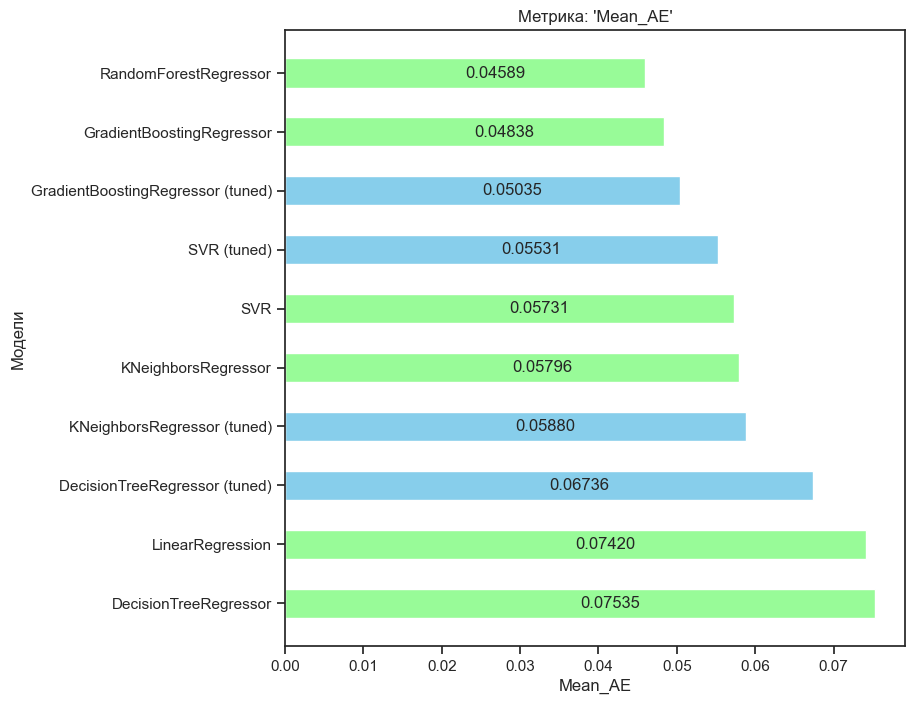

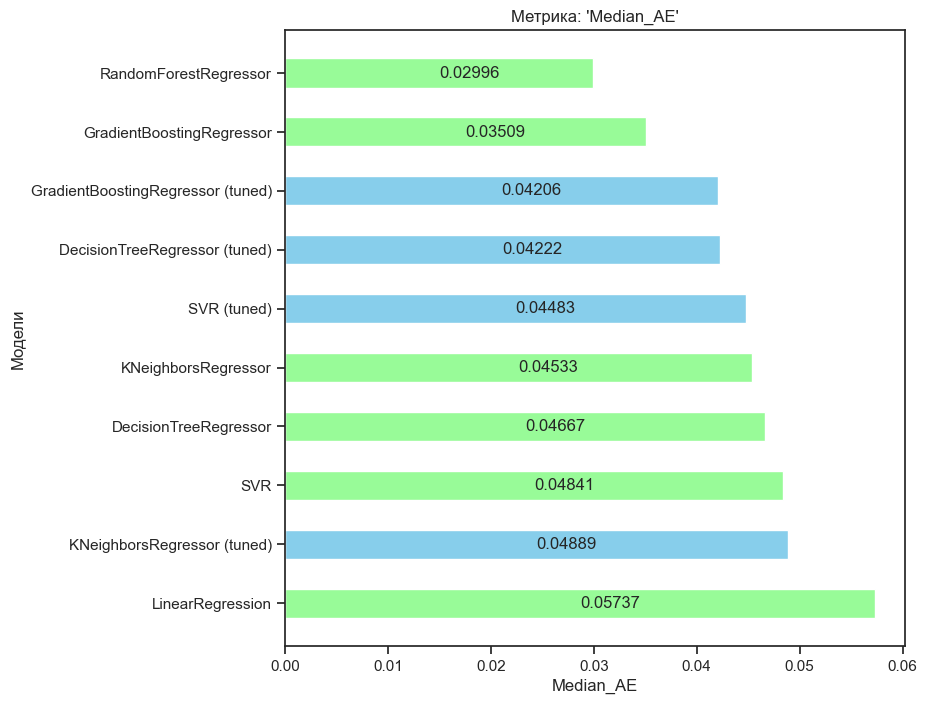

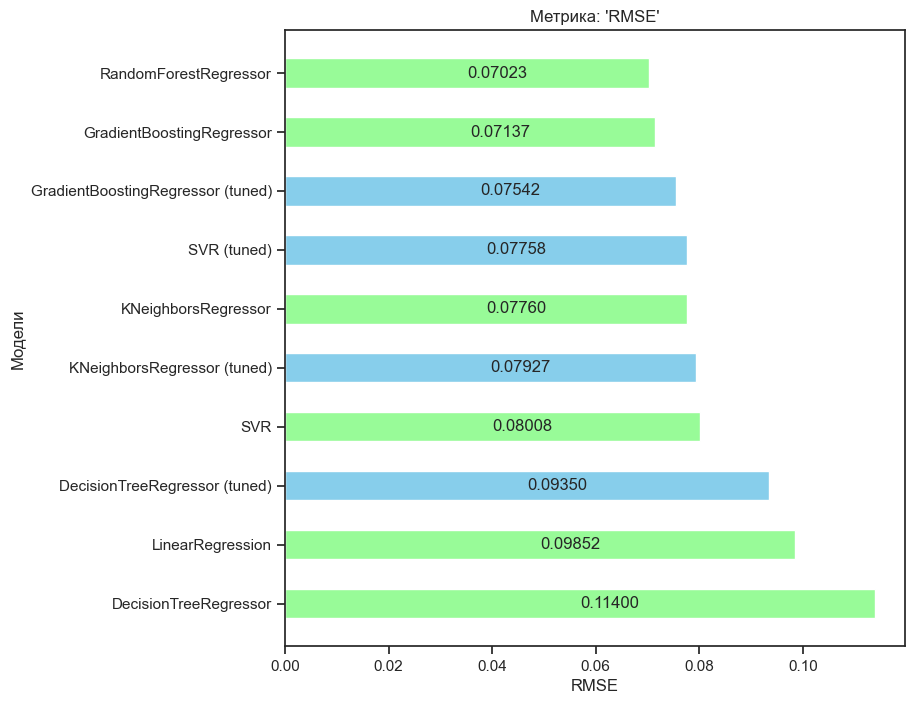

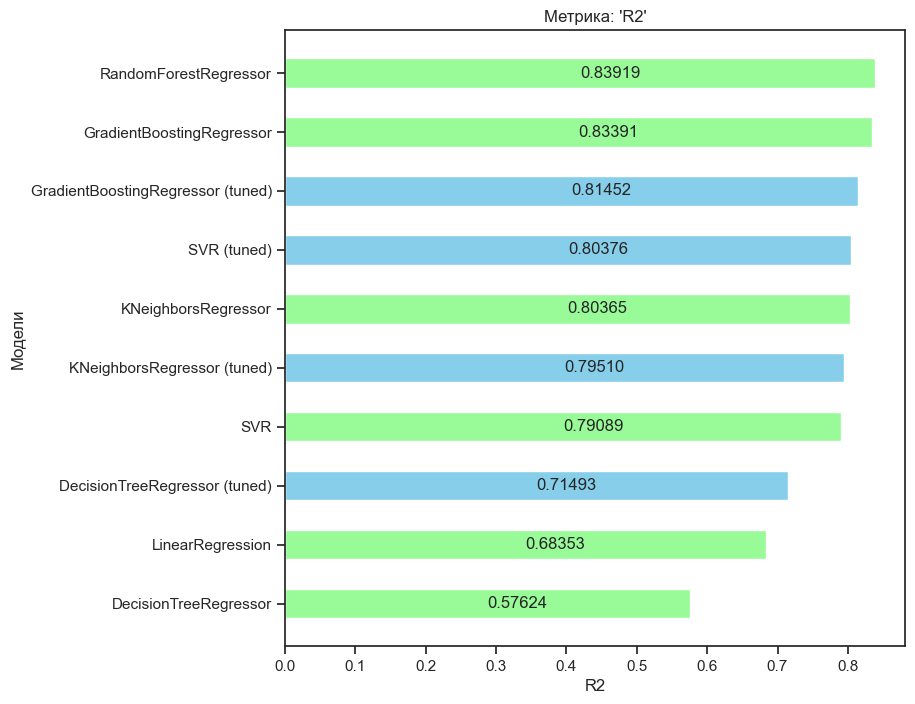

In [32]:
metrics = ["Mean_AE", "Median_AE", "RMSE", "R2"]
for metric in metrics:
    tester.vis_models_quality(metric)

### **Вывод:**
Модель случайного леса с начальными параметрами показала результаты лучше по всем метрикам. Градиентный бустинг также показал сравнительно хорошие результаты.